# Carga de librerias y datos

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia
!pip install catboost

udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
!unzip udea*.zip > /dev/null

replace submission_example.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline
dtr= pd.read_csv("train.csv")

# PREPROCESAMIENTO

## DATOS BOOLEANOS

In [4]:
def mask(x):
  if x=="Si":
    return bool(True)
  elif x=="No":
    return bool(False)
  else:
    return
#Se define una mascara para que los datos queden en el tipo adecuado

In [5]:
for i in ['FAMI_TIENEINTERNET','FAMI_TIENELAVADORA','FAMI_TIENEAUTOMOVIL','ESTU_PAGOMATRICULAPROPIO','FAMI_TIENECOMPUTADOR','FAMI_TIENEINTERNET.1']:
  dtr[i]=dtr[i].apply(mask)

In [6]:
del dtr['FAMI_TIENEINTERNET.1'] #Observamos que es una variable repetida por lo cual borramos una de las columnas

In [7]:
def mask1(x):
  if x=="S":
    return bool(True)
  elif x=="N":
    return bool(False)
  else:
    return
#Mascara para variable particular

In [8]:
dtr['ESTU_PRIVADO_LIBERTAD']=dtr['ESTU_PRIVADO_LIBERTAD'].apply(mask1)

In [9]:
bool_var= ['FAMI_TIENEINTERNET','FAMI_TIENELAVADORA','FAMI_TIENEAUTOMOVIL','ESTU_PAGOMATRICULAPROPIO','FAMI_TIENECOMPUTADOR','ESTU_PRIVADO_LIBERTAD']

In [10]:
for col in bool_var:
  dtr[col]=dtr[col].fillna(dtr[col].mode(dropna=True)[0])
  #Al ser datos booleanos, y la cantidad de faltantes no muy alta, se decide llenar los datos faltantes con la moda de cada una de las columnas

/tmp/ipython-input-10-3536273753.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dtr[col]=dtr[col].fillna(dtr[col].mode(dropna=True)[0])


## Datos categoricos mapeables

Hay una buena cantidad de columnas que tienen una estructura ordenada por lo cual para simplicidad de los datos podriamos mapearlos en integrers ordenadas, en ciertos casos se toma la decisión de llenar los valores faltantes con 0, la media, o una categoría nueva segun tenga sentido.

In [11]:
mapa_matricula = {
    'Menos de 500 mil': 1,
    'Entre 500 mil y menos de 1 millón': 2,
    'Entre 1 millón y menos de 2.5 millones': 3,
    'Entre 2.5 millones y menos de 4 millones': 4,
    'Entre 4 millones y menos de 5.5 millones': 5,
    'Entre 5.5 millones y menos de 7 millones': 6,
    'Más de 7 millones': 7,
    'No pagó matrícula': 0,
}
dtr['ESTU_VALORMATRICULAUNIVERSIDAD'] = dtr['ESTU_VALORMATRICULAUNIVERSIDAD'].map(mapa_matricula)

In [12]:
dtr['ESTU_VALORMATRICULAUNIVERSIDAD']=dtr['ESTU_VALORMATRICULAUNIVERSIDAD'].fillna(round(dtr['ESTU_VALORMATRICULAUNIVERSIDAD'].mean()))

In [13]:
mapa_trabajo = {
    '0': 0,
    'Menos de 10 horas': 1,
    'Entre 11 y 20 horas': 2,
    'Entre 21 y 30 horas': 3,
    'Más de 30 horas': 4
}

dtr['ESTU_HORASSEMANATRABAJA'] = dtr['ESTU_HORASSEMANATRABAJA'].map(mapa_trabajo)
dtr['ESTU_HORASSEMANATRABAJA'] = dtr['ESTU_HORASSEMANATRABAJA'].fillna(round(dtr['ESTU_HORASSEMANATRABAJA'].mean()))

In [14]:
dtr['FAMI_ESTRATOVIVIENDA']=dtr['FAMI_ESTRATOVIVIENDA'].fillna('ns/nr')

In [15]:
for col in ['FAMI_EDUCACIONMADRE','FAMI_EDUCACIONPADRE']:
  dtr[col]=dtr[col].fillna('desconocido')

In [16]:
dtr.isnull().any()

,0
ID,False
PERIODO,False
ESTU_PRGM_ACADEMICO,False
ESTU_PRGM_DEPARTAMENTO,False
ESTU_VALORMATRICULAUNIVERSIDAD,False
ESTU_HORASSEMANATRABAJA,False
FAMI_ESTRATOVIVIENDA,False
FAMI_TIENEINTERNET,False
FAMI_EDUCACIONPADRE,False
FAMI_TIENELAVADORA,False


In [17]:
Var_categoricas=['FAMI_EDUCACIONMADRE','FAMI_EDUCACIONPADRE','FAMI_ESTRATOVIVIENDA','ESTU_PRGM_ACADEMICO','ESTU_PRGM_DEPARTAMENTO']
for col in Var_categoricas:
  dtr[col]=dtr[col].astype(str)

In [18]:
del dtr['coef_1'], dtr['coef_2'], dtr['coef_3'], dtr['coef_4'],dtr['ESTU_PRIVADO_LIBERTAD'],dtr['FAMI_TIENELAVADORA'],dtr['FAMI_TIENEAUTOMOVIL']

Se toma la decision de borrar estas variables ya que en varias iteraciones con el catboost se observo que tenian baja importancia

#Entrenamiento,

In [19]:
dtr.shape

(692500, 13)

In [20]:
dtr_copy=dtr.copy()
le=LabelEncoder()
y=le.fit_transform(dtr_copy['RENDIMIENTO_GLOBAL'])
X=dtr_copy.drop(columns=["RENDIMIENTO_GLOBAL", "ID", "PERIODO"] )
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
var_map = ['ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA']
Var_categoricas=['FAMI_EDUCACIONMADRE','FAMI_EDUCACIONPADRE','FAMI_ESTRATOVIVIENDA','ESTU_PRGM_ACADEMICO','ESTU_PRGM_DEPARTAMENTO']

In [22]:
#Entrenamos el modelo

# Debemos asegurarnos que las variables categoricas estén codificadas cómo tal para que el modelo funcione correctamente
for col in Var_categoricas:
    x_train[col] = x_train[col].astype('category')
    x_val[col] = x_val[col].astype('category')

# Establecemos el clasificador
classifier = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, loss_function='MultiClass',
                                 cat_features=Var_categoricas, verbose=10)

classifier.fit(x_train, y_train)

#Realizamos la predicción en validación

y_val_pred = classifier.predict(x_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy validación: {val_accuracy:.4f}")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

0:	learn: 1.3695661	total: 3.45s	remaining: 5m 42s
10:	learn: 1.2717888	total: 14.9s	remaining: 2m
20:	learn: 1.2420957	total: 32.6s	remaining: 2m 2s
30:	learn: 1.2303055	total: 48.4s	remaining: 1m 47s
40:	learn: 1.2245280	total: 59.3s	remaining: 1m 25s
50:	learn: 1.2212450	total: 1m 10s	remaining: 1m 7s
60:	learn: 1.2185728	total: 1m 21s	remaining: 51.9s
70:	learn: 1.2156830	total: 1m 31s	remaining: 37.5s
80:	learn: 1.2136602	total: 1m 44s	remaining: 24.4s
90:	learn: 1.2118715	total: 1m 55s	remaining: 11.4s
99:	learn: 1.2108458	total: 2m 4s	remaining: 0us
Accuracy validación: 0.4289
              precision    recall  f1-score   support

        alto       0.55      0.62      0.59     35165
        bajo       0.45      0.56      0.50     34573
  medio-alto       0.32      0.27      0.30     34259
  medio-bajo       0.32      0.25      0.28     34503

    accuracy                           0.43    138500
   macro avg       0.41      0.43      0.42    138500
weighted avg       0.41      

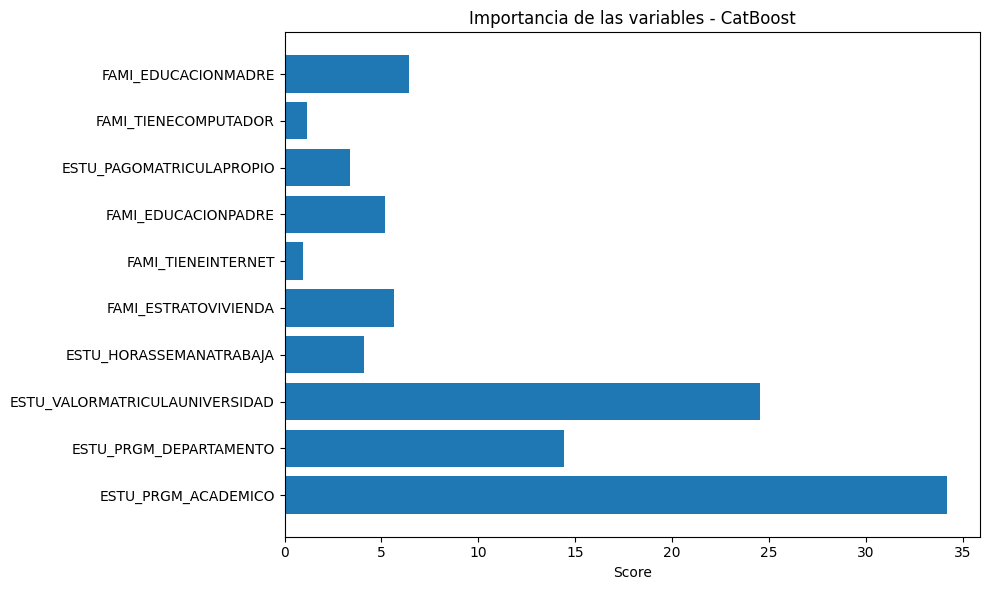

In [23]:
feat_imp = classifier.get_feature_importance()
features = x_train.columns

plt.figure(figsize=(10,6))
plt.barh(features, feat_imp)
plt.title("Importancia de las variables - CatBoost")
plt.xlabel("Score")
plt.tight_layout()
plt.show()

Ahora para la subida a Kaggle debemos adaptar los datos de test a los mapas establecidos.

In [24]:
dtest= pd.read_csv("test.csv")

In [25]:
for i in ['FAMI_TIENEINTERNET','FAMI_TIENELAVADORA','FAMI_TIENEAUTOMOVIL','ESTU_PAGOMATRICULAPROPIO','FAMI_TIENECOMPUTADOR','FAMI_TIENEINTERNET.1']:
  dtest[i]=dtest[i].apply(mask)
del dtest['FAMI_TIENEINTERNET.1']
dtest['ESTU_PRIVADO_LIBERTAD']=dtest['ESTU_PRIVADO_LIBERTAD'].apply(mask1)
for col in bool_var:
  dtest[col]=dtest[col].fillna(dtest[col].mode(dropna=True)[0])
dtest['ESTU_VALORMATRICULAUNIVERSIDAD'] = dtest['ESTU_VALORMATRICULAUNIVERSIDAD'].map(mapa_matricula)
dtest['ESTU_VALORMATRICULAUNIVERSIDAD']=dtest['ESTU_VALORMATRICULAUNIVERSIDAD'].fillna(round(dtest['ESTU_VALORMATRICULAUNIVERSIDAD'].mean()))
dtest['ESTU_HORASSEMANATRABAJA'] = dtest['ESTU_HORASSEMANATRABAJA'].map(mapa_trabajo)
dtest['ESTU_HORASSEMANATRABAJA'] = dtest['ESTU_HORASSEMANATRABAJA'].fillna(round(dtr['ESTU_HORASSEMANATRABAJA'].mean()))
dtest['FAMI_ESTRATOVIVIENDA']=dtest['FAMI_ESTRATOVIVIENDA'].fillna('ns/nr')
for col in ['FAMI_EDUCACIONMADRE','FAMI_EDUCACIONPADRE']:
  dtest[col]=dtest[col].fillna('desconocido')
Var_categoricas=['FAMI_EDUCACIONMADRE','FAMI_EDUCACIONPADRE','FAMI_ESTRATOVIVIENDA','ESTU_PRGM_ACADEMICO','ESTU_PRGM_DEPARTAMENTO']
for col in Var_categoricas:
  dtest[col]=dtest[col].astype(str)
del dtest['coef_1'], dtest['coef_2'], dtest['coef_3'], dtest['coef_4'],dtest['ESTU_PRIVADO_LIBERTAD'],dtest['FAMI_TIENELAVADORA'],dtest['FAMI_TIENEAUTOMOVIL']

/tmp/ipython-input-25-367623178.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dtest[col]=dtest[col].fillna(dtest[col].mode(dropna=True)[0])


In [27]:
x_kaggle = dtest.drop(columns=["ID", "PERIODO"], errors='ignore')
predictions = classifier.predict(x_kaggle)
predictions_labels = le.inverse_transform(predictions)
kaggle_dtest = dtest[["ID"]].copy()
kaggle_dtest["RENDIMIENTO_GLOBAL"] = predictions_labels
kaggle_dtest.to_csv("submission_dtest_catboost.csv", index=False)
print(kaggle_dtest.head())

       ID RENDIMIENTO_GLOBAL
0  550236               bajo
1   98545         medio-bajo
2  499179               alto
3  782980               bajo
4  785185               bajo


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
